In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import cm

import sys
import os
core_dir = os.path.join(os.getcwd(), '..', 'daphme')
core_dir = os.path.normpath(core_dir)
sys.path.append(core_dir)

import garden_city as gcity
from garden_city import Building, Street, City, Agent, Population
import mobility_model as mmod
import stop_detection as sd
from constants import DEFAULT_SPEEDS, FAST_SPEEDS, SLOW_SPEEDS, DEFAULT_STILL_PROBS, FAST_STILL_PROBS, SLOW_STILL_PROBS

import pdb

Initialization of city and population

In [2]:
city = gcity.load('garden-city.pkl')
population = Population(city)

# Definitions

In [3]:
def q_stat(agent):
    # How to handle partial hours? If last ping is 18:00, count that hour or not?

    sparse_traj = agent.sparse_traj
    traj = agent.trajectory

    if sparse_traj.empty:
        return 0

    sparse_hours = sparse_traj['local_timestamp'].dt.to_period('H')
    full_hours = traj['local_timestamp'].dt.to_period('H')
    num_hours = sparse_hours.nunique()
    total_hours = full_hours.nunique()
    q_stat = num_hours / total_hours
    return q_stat

In [4]:
def expand_timestamps(df):
    """
    Expands timestamps to individual minutes.
    """
    # Repeat rows based on duration
    repeated_df = df.loc[df.index.repeat(df['duration'])].reset_index(drop=True)

    # Generate the time increments
    repeated_df['minute_increment'] = repeated_df.groupby(['local_timestamp', 'stop_id']).cumcount()
    repeated_df['local_timestamp'] = repeated_df['local_timestamp'] + pd.to_timedelta(repeated_df['minute_increment'], unit='m')
    expanded = repeated_df.drop(columns=['minute_increment', 'duration'])

    expanded['unix_timestamp'] = expanded['local_timestamp'].view('int64') // 10**9
    expanded = expanded.set_index('unix_timestamp', drop=True)

    return expanded


def prepare_diary(agent):
    """
    Create stop ids, expand to minute level, and filter diary
    to stops that have at least one ping in the sparse trajectory.
    """
    diary = agent.diary.copy()
    sparse_traj = agent.sparse_traj

    # stop_id of moves is -1. Stays are id'ed as 0, 1, 2, ...
    mask = diary['location'].notna()
    diary['stop_id'] = np.where(mask, np.cumsum(mask) - 1, -1)

    # Expand to minute level
    prepared_diary = expand_timestamps(diary)

    # Filter diary to stops that have at least one ping in the sparse trajectory
    stop_ids = prepared_diary['stop_id']
    idx = stop_ids.index.intersection(sparse_traj.index)
    stop_ids = stop_ids.loc[idx]
    stop_ids = pd.concat([stop_ids, pd.Series([-1], name="stop_id")], ignore_index=True)  # ensure moves are kept
    keep = stop_ids.unique()

    prepared_diary = prepared_diary[prepared_diary['stop_id'].isin(keep)]
    return prepared_diary, diary


def prepare_stop_table(stop_table, diary):
    """
    Maps detected stops to diary stops via overlapping location and timeframe,
    and expand to minute level
    """
    keep = stop_table.columns.tolist() + ['stop_id']

    stop_table['end_time'] = stop_table['local_timestamp'] + pd.to_timedelta(stop_table['duration'], unit='m')
    diary['end_time'] = diary['local_timestamp'] + pd.to_timedelta(diary['duration'], unit='m')

    # merge_asof gets stop_table['local_timestamp'] <= diary['end_time'] by location
    joined = pd.merge_asof(
        stop_table,
        diary,
        left_on='local_timestamp',
        right_on='end_time',
        by='location',
        suffixes=('', '_diary'),
        direction='forward'
    )

    # Ensure diary['local_timestamp'] <= stop_table['end_time']
    mask = joined['local_timestamp_diary'] <= joined['end_time']

    # Select the first matching stop_id if multiple matches are found
    joined['stop_id'] = joined.loc[mask, 'stop_id']

    stop_table = joined[keep]
    prepared_stop_table = expand_timestamps(stop_table)  # expand to minute level

    return prepared_stop_table, stop_table


def cluster_metrics(stop_table, agent):
    """
    Multiclass classification: compute precision, recall for each class separately,
    then use microaveraging to get the overall precision and recall.
    We could also try duration-weighted macroaveraging.
    """

    # Prepare diary
    prepared_diary, diary = prepare_diary(agent)

    # Prepare stop table
    prepared_stop_table, stop_table = prepare_stop_table(stop_table, diary)

    # Count number of rows in stop_table that match each stop_id in diary
    stop_counts = stop_table['stop_id'].value_counts().reset_index()
    stop_counts.columns = ['stop_id', 'stop_count']

    # Merge on timestamps and locations
    prepared_stop_table['stop_id'].fillna(-2, inplace=True)  # -2 refers to stops detected by the sd alg that don't exist in ground truth
    joined = prepared_diary.merge(prepared_stop_table, on=['unix_timestamp', 'stop_id'], how='outer', indicator=True)

    # Duplicated indices denotes conflicting stop labels for the timestamp
    merging_df = joined[joined.index.duplicated(keep=False)]

    # Calculate metrics for each class
    stops = joined['stop_id'].unique()
    stops = stops[stops != -2]
    stops.sort()
    metrics_data = []

    for s in stops:
        s_joined = joined[joined['stop_id'] == s]
        s_tp = s_joined[s_joined['_merge'] == 'both'].shape[0]
        s_fp = s_joined[s_joined['_merge'] == 'right_only'].shape[0]
        s_fn = s_joined[s_joined['_merge'] == 'left_only'].shape[0]

        s_merging = merging_df[(merging_df['_merge'] == 'left_only') & (merging_df['stop_id'] == s)]
        s_m = s_merging.shape[0]
        s_m_stops = merging_df.loc[s_merging.index]
        s_m_stops = s_m_stops[(s_m_stops['_merge'] == 'right_only')]
        s_m_stops = s_m_stops['stop_id'].nunique()

        metrics_data.append({
            'stop_id': s,
            'tp': s_tp,
            'fp': s_fp,
            'fn': s_fn,
            'precision': s_tp / (s_tp + s_fp) if (s_tp + s_fp) != 0 else 0,
            'recall': s_tp / (s_tp + s_fn) if (s_tp + s_fn) != 0 else 0,
            'pings_merged': s_m,
            'stops_merged': s_m_stops,
            'prop_merged': s_m / (s_tp + s_fn) if (s_tp + s_fn) != 0 else 0,
        })

    moves = metrics_data[0]
    metrics_df = pd.DataFrame(metrics_data[1:])
    metrics_df = diary.merge(metrics_df, on=['stop_id'], how='right')
    metrics_df = metrics_df.merge(stop_counts, on=['stop_id'], how='left')
    metrics_df = metrics_df.set_index('stop_id')
    metrics_df['stop_count'] = metrics_df['stop_count'].fillna(0).astype(int)

    tp = metrics_df['tp'].sum()
    fp = metrics_df['fp'].sum()
    fn = metrics_df['fn'].sum()
    stops_merged = metrics_df['stops_merged'].sum()

    # Calculate micro-averaged precision and recall
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0

    # Calculate macro-averaged precision and merging, weighted by duration of stop
    total_duration = metrics_df['duration'].sum()  # total duration = tp + fn
    weighted_precision = (metrics_df['precision'] * metrics_df['duration']).sum() / total_duration
    weighted_merging = (metrics_df['prop_merged'] * metrics_df['duration']).sum() / total_duration

    # Tabulate number of missed and split stops
    num_missed = metrics_df[metrics_df['stop_count'] == 0].shape[0]
    num_split = metrics_df[metrics_df['stop_count'] > 1].shape[0]

    metrics = {
        "Recall": recall,
        "Precision": precision,
        "Weighted Precision": weighted_precision,
        "Missed": num_missed,
        "Stops Merged": stops_merged,
        "Weighted Stop Merging": weighted_merging,
        "Move Merging": moves['prop_merged'],
        "Split": num_split
    }

    return metrics_df, metrics

# Demonstration: Stop Detection Metrics

Initialize agent with a true trajectory and a sparse sampled trajectory.

In [5]:
seed = 207

start_time = [datetime(2024, 6, 1, hour=8, minute=0) + timedelta(minutes=60*t) for t in range(9)]
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [60]*9
location = ['h-x13-y9'] * 1 + ['h-x13-y8'] * 1 + ['w-x3-y13'] * 3 + ['h-x8-y13'] * 1 + ['h-x9-y13'] * 1 + ['w-x8-y18'] * 2

destination = pd.DataFrame(
    {"unix_timestamp": unix_timestamp, "local_timestamp": start_time,
     "duration": duration, "location": location}
)
destination = gcity.condense_destinations(destination)

Paco = Agent('Paco',
             'h-x13-y9',
             'w-x3-y13',
             city,
             destination_diary=destination)

population.add_agent(Paco)
population.generate_trajectory(Paco, seed=seed, dt=1)

hier_nhpp_params = (90, 45, 3)
Paco.sample_traj_hier_nhpp(*hier_nhpp_params, seed=seed)

Plot sparse sampled trajectory.

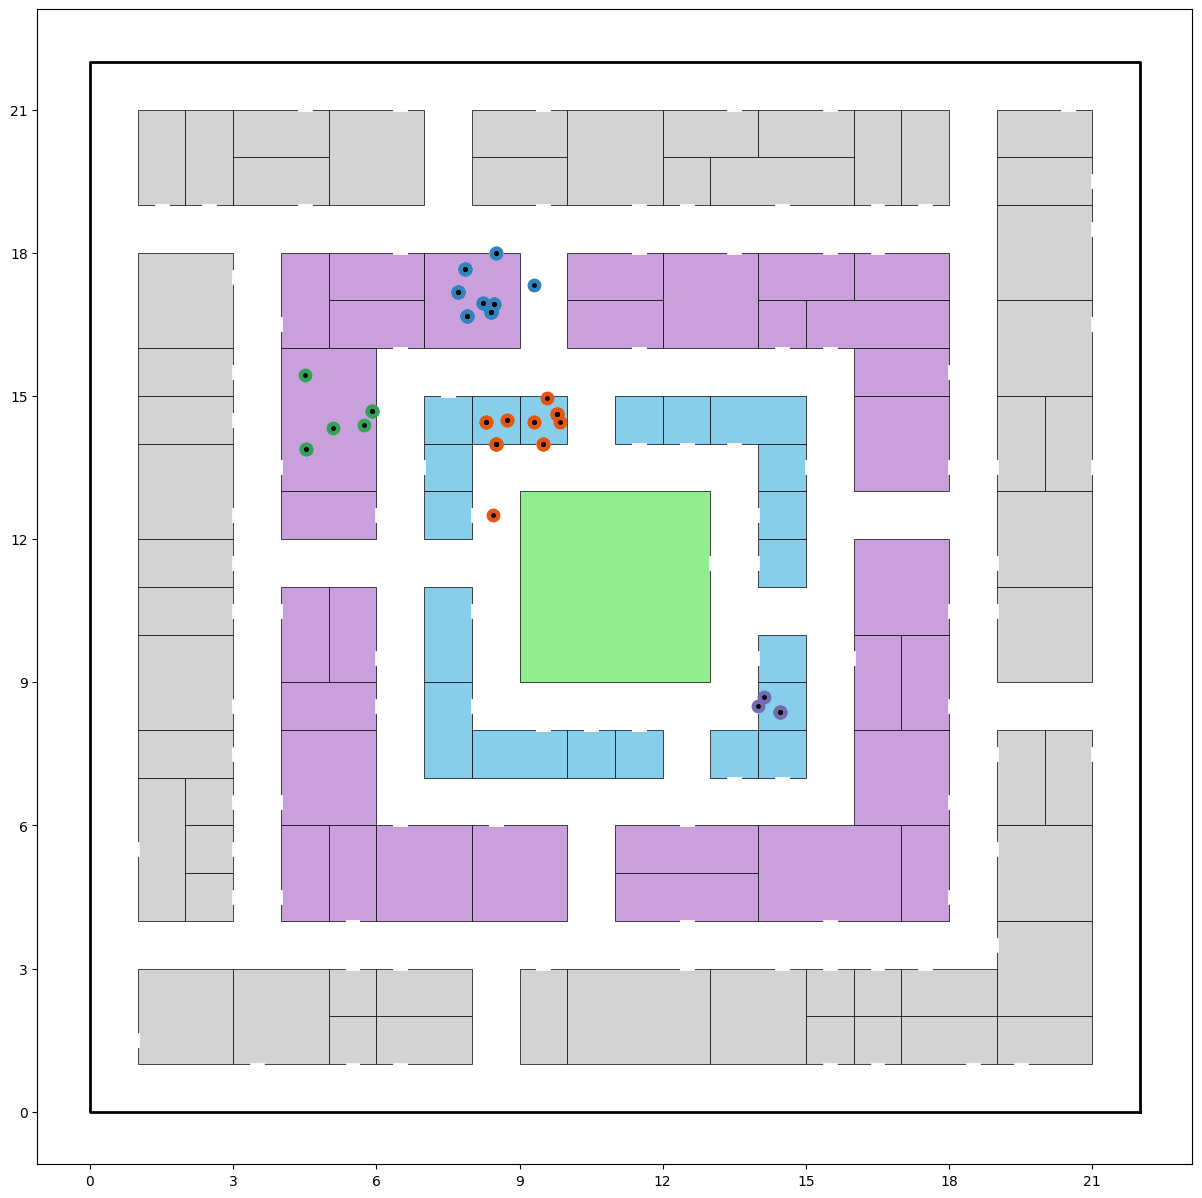

In [6]:
%matplotlib inline

dbscan_params = [(240, 2, 2), (60, 0.5, 3)]

dbscan_out = sd.temporal_dbscan(Paco.sparse_traj, *dbscan_params[0])

fig, ax = plt.subplots(figsize=(15, 15))

num_clusters = sum(dbscan_out.cluster.unique() > -1)
for cid in range(num_clusters):
    cpings = dbscan_out[dbscan_out.cluster == cid]
    cdata = Paco.sparse_traj.loc[cpings.index]
    col = cm.tab20c(cid/(num_clusters+1))
    ax.scatter(cdata.x, cdata.y, s=80, color=col, alpha=1, zorder=2)

ax.scatter(Paco.sparse_traj.x, Paco.sparse_traj.y, s=6, color='black', alpha=1, zorder=2)
city.plot_city(ax, doors=True, address=True, zorder=1)

plt.show()

In [7]:
Paco_stop_table = sd.generate_stop_table(Paco.sparse_traj, dbscan_out)
Paco_stop_table['location'] = Paco_stop_table.apply(lambda row: city.get_block((row.centroid_x, row.centroid_y)).id, axis=1)

#Paco_stop_table

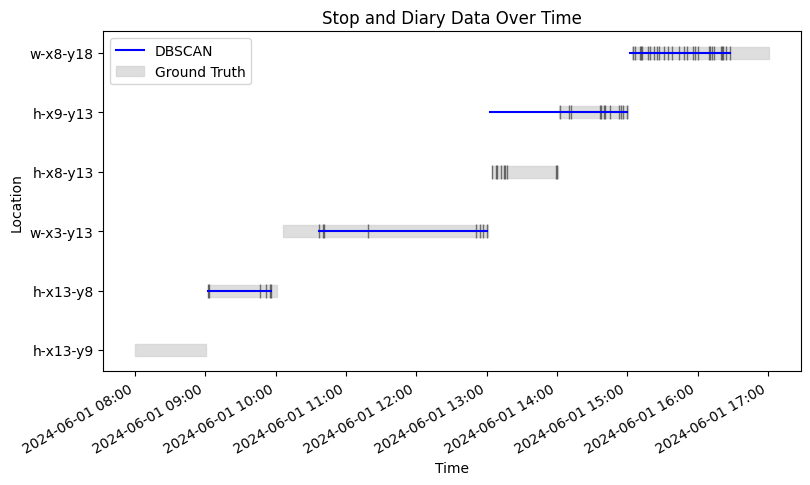

In [8]:
diary = Paco.diary.dropna().copy()
stop_table = Paco_stop_table.copy()
sparse_traj = Paco.sparse_traj.copy()

location_mapping = {loc: idx for idx, loc in enumerate(diary['location'].unique())}
diary['location_num'] = diary['location'].map(location_mapping)
stop_table['location_num'] = stop_table['location'].map(location_mapping)

# Create the plot
plt.figure(figsize=(9, 5))

# Plot stop_table
for idx, row in stop_table.iterrows():
    start_time = row['local_timestamp']
    end_time = start_time + pd.Timedelta(minutes=row['duration'])
    plt.plot([start_time, end_time], [row['location_num'], row['location_num']], color='blue', label='DBSCAN' if idx == 0 else "", zorder=3)

# Plot diary data with shaded rectangles
for idx, row in diary.iterrows():
    start_time = row['local_timestamp']
    end_time = start_time + pd.Timedelta(minutes=row['duration'])
    plt.fill_between([start_time, end_time], [row['location_num'] - 0.1, row['location_num'] - 0.1], [row['location_num'] + 0.1, row['location_num'] + 0.1], color='lightgrey', alpha=0.75, label='Ground Truth' if idx == 0 else "", zorder=1)
    pings = sparse_traj[(sparse_traj['local_timestamp'] >= start_time) & (sparse_traj['local_timestamp'] <= end_time)]
    pings = pings['local_timestamp'].to_frame()
    pings['location_num'] = row['location_num']
    plt.plot(pings['local_timestamp'], pings['location_num'], '|', markersize=10, color='black', alpha=0.5, zorder=2)

# Plot pings in sparse traj

# Format the x-axis to show dates properly
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.HourLocator(interval=1))
plt.gcf().autofmt_xdate()  # Rotate date labels automatically

# Set labels and title
plt.xlabel('Time')
plt.ylabel('Location')
plt.title('Stop and Diary Data Over Time')
plt.yticks(ticks=list(location_mapping.values()), labels=list(location_mapping.keys()))

# Add legend
plt.legend()

# Show the plot
plt.show()

In [9]:
stop_table = Paco_stop_table.copy()

metrics_df, metrics = cluster_metrics(stop_table, Paco)
metrics

{'Recall': 0.7274678111587983,
 'Precision': 0.8475,
 'Weighted Precision': 0.8101436330800539,
 'Missed': 1,
 'Stops Merged': 1,
 'Weighted Stop Merging': 0.12017167381974249,
 'Move Merging': 0.35714285714285715,
 'Split': 0}

In [10]:
metrics_df

,unix_timestamp,local_timestamp,duration,location,end_time,tp,fp,fn,precision,recall,pings_merged,stops_merged,prop_merged,stop_count
stop_id,,,,,,,,,,,,,,
1,1717232520,2024-06-01 09:02:00,59,h-x13-y8,2024-06-01 10:01:00,54,0,5,1.000000,0.915254,0,0,0.0,1
2,1717236360,2024-06-01 10:06:00,175,w-x3-y13,2024-06-01 13:01:00,143,0,32,1.000000,0.817143,0,0,0.0,1
3,1717247100,2024-06-01 13:05:00,56,h-x8-y13,2024-06-01 14:01:00,0,0,56,0.000000,0.000000,56,1,1.0,0
4,1717250520,2024-06-01 14:02:00,59,h-x9-y13,2024-06-01 15:01:00,58,59,1,0.495726,0.983051,0,0,0.0,1
5,1717254240,2024-06-01 15:04:00,117,w-x8-y18,2024-06-01 17:01:00,84,2,33,0.976744,0.717949,0,0,0.0,1


# Curves

### Fix DBSCAN parameterization: fine vs coarse. Vary burstiness pattern by changing third param (mean gap between pings in a burst) and fixing overall mean of 12 pings per hour.

In [11]:
start_time = [datetime(2024, 6, 1, hour=8, minute=0) + timedelta(minutes=60*t) for t in range(9)]
unix_timestamp = [int(t.timestamp()) for t in start_time]
duration = [60]*9
location = ['h-x13-y9'] * 1 + ['h-x13-y8'] * 1 + ['w-x3-y13'] * 3 + ['h-x8-y13'] * 1 + ['h-x9-y13'] * 1 + ['w-x8-y18'] * 2

destination = pd.DataFrame(
    {"unix_timestamp": unix_timestamp, "local_timestamp": start_time,
     "duration": duration, "location": location}
)
destination = gcity.condense_destinations(destination)

In [12]:
seeds = range(100, 150)
burstiness_range = range(1, 31)
dbscan_params = [(240, 2, 2), (60, 0.5, 3)]
beta_start = 90
pph = 12  # mean pings per hour

results = np.zeros((len(seeds), len(burstiness_range), len(dbscan_params), 8))

for i, seed in enumerate(seeds):
    Bethany = Agent('Bethany',
                    'h-x13-y9',
                    'w-x3-y13',
                     city,
                     destination_diary=destination)
    population.add_agent(Bethany, verbose=False)
    population.generate_trajectory(Bethany, seed=seed, dt=1)

    for j, beta_ping in enumerate(burstiness_range):
        beta_durations = (pph * beta_start * beta_ping) / 60
        hier_nhpp_params = (beta_start, beta_durations, beta_ping)
        Bethany.sample_traj_hier_nhpp(*hier_nhpp_params, seed=seed)

        for k, dbscan_param in enumerate(dbscan_params):
            dbscan_out = sd.temporal_dbscan(Bethany.sparse_traj, *dbscan_param)
            stop_table = sd.generate_stop_table(Bethany.sparse_traj, dbscan_out)

            if stop_table.empty:
                prepared_diary, _ = prepare_diary(Bethany)
                n_stops = np.sum(prepared_diary['stop_id'].unique() > 0)

                results[i, j, k, 0] = beta_ping
                results[i, j, k, 1] = 0  # Recall
                results[i, j, k, 2] = 0  # Precision
                results[i, j, k, 3] = None  # Weighted Stop Merging
                results[i, j, k, 4] = None  # Move Merging
                results[i, j, k, 5] = n_stops  # Stops missed
                results[i, j, k, 6] = None  # Stops split
                results[i, j, k, 7] = None  # q
                continue

            stop_table['location'] = stop_table.apply(lambda row: city.get_block((row.centroid_x, row.centroid_y)).id, axis=1)
            metrics_df, metrics = cluster_metrics(stop_table, Bethany)

            results[i, j, k, 0] = beta_ping
            results[i, j, k, 1] = metrics['Recall']
            results[i, j, k, 2] = metrics['Precision']
            results[i, j, k, 3] = metrics['Weighted Stop Merging']
            results[i, j, k, 4] = metrics['Move Merging']
            results[i, j, k, 5] = metrics['Missed']
            results[i, j, k, 6] = metrics['Split']
            results[i, j, k, 7] = q_stat(Bethany)

    print(seed)

results_burstiness = np.nanmean(results, axis=0)

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


Agent identifier already exists in population. Replacing corresponding agent.


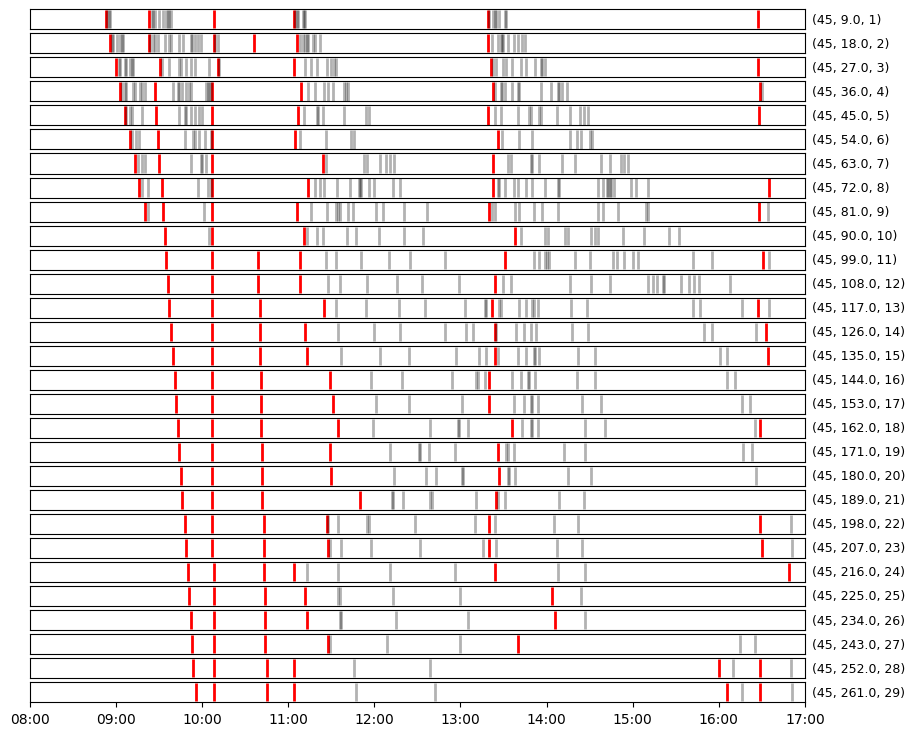

In [13]:
import matplotlib.dates as mdates
%matplotlib inline

seed = 120
burstiness_range = range(1, 30)
beta_start = 45
pph = 12 # mean pings per hour

Bethany = Agent('Bethany',
                'h-x13-y9',
                'w-x3-y13',
                city,
                destination_diary=destination)
population.add_agent(Bethany)

population.generate_trajectory(Bethany, seed=seed, dt=1)

fig, axes = plt.subplots(len(burstiness_range), 1, figsize=(10, 9))

for i, beta_ping in enumerate(burstiness_range):
    ax = axes[i]
    beta_durations = (pph * beta_start * beta_ping) / 60
    hier_nhpp_params = (beta_start, beta_durations, beta_ping)
    Bethany.sample_traj_hier_nhpp(*hier_nhpp_params, seed=seed)

    first_ping_timestamps = Bethany.sparse_traj[Bethany.sparse_traj['first_ping'] == 1]['local_timestamp']
    other_timestamps = Bethany.sparse_traj[Bethany.sparse_traj['first_ping'] == 0]['local_timestamp']

    ax.vlines(first_ping_timestamps, 0.95, 1.05, color='red', linewidth=2, alpha=1)
    ax.vlines(other_timestamps, 0.95, 1.05, color='black', linewidth=2, alpha=0.30)

    #ax.vlines(Thomtraj['local_timestamp'], 0.95, 1.05, color='black', linewidth=2, alpha=0.2)

    ax.set_xlim(pd.Timestamp('2024-06-01 08:00'), pd.Timestamp('2024-06-01 17:00'))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    #plt.xticks(rotation=0)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.text(pd.Timestamp('2024-06-01 17:05'), 0.98, hier_nhpp_params, fontsize=9, ha='left')

axes[-1].xaxis.set_visible(True)
plt.show()

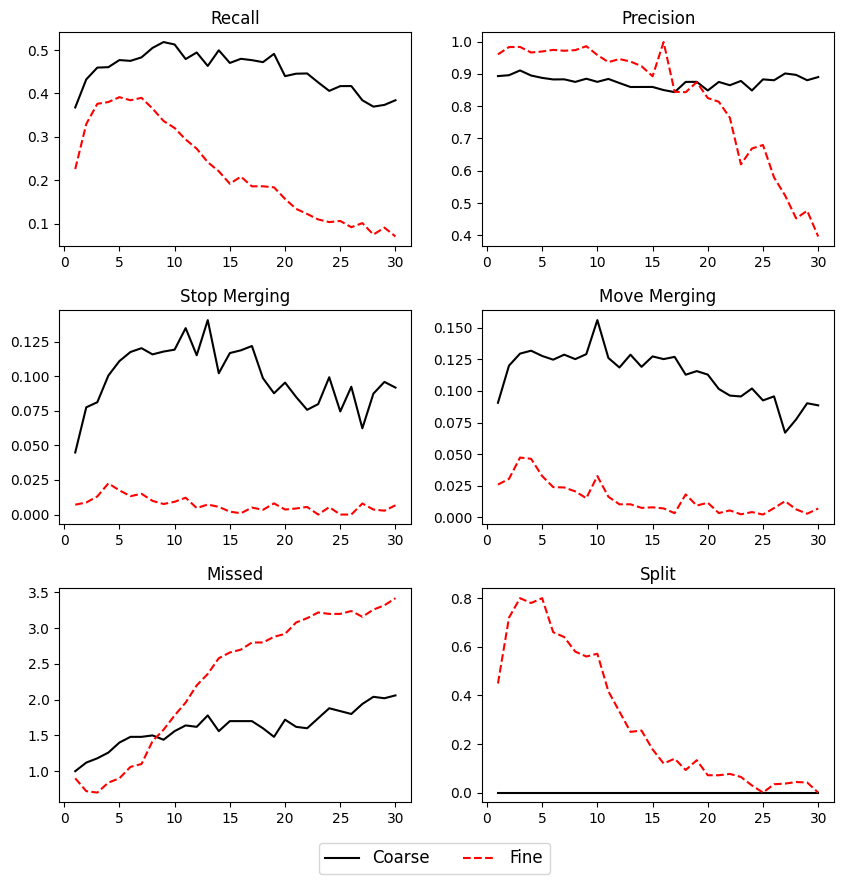

In [14]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

for i in range(6):
    ax = axes[i//2, i % 2]
    for j in range(2):
        results_df = pd.DataFrame(
            results_burstiness[:, j, :],
            columns=['beta_ping', 'recall', 'precision', 'weighted_stop_merging', 'move_merging', 'missed', 'split', 'q_stat'])
        ax.plot(results_df['beta_ping'], results_df.iloc[:, i+1],
                label=['Coarse', 'Fine'][j], color=['black', 'red'][j], linestyle=['-', '--'][j])
        ax.set_title(['Recall', 'Precision', 'Stop Merging', 'Move Merging', 'Missed', 'Split'][i])
        ax.set_ylabel('')

#fig.suptitle('Metrics v.s. Sparsity', fontsize=20)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize='large',
           ncol=2, bbox_to_anchor=(0.5, 0.03))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

plt.savefig("metrics_vs_burstiness.png")
plt.show()

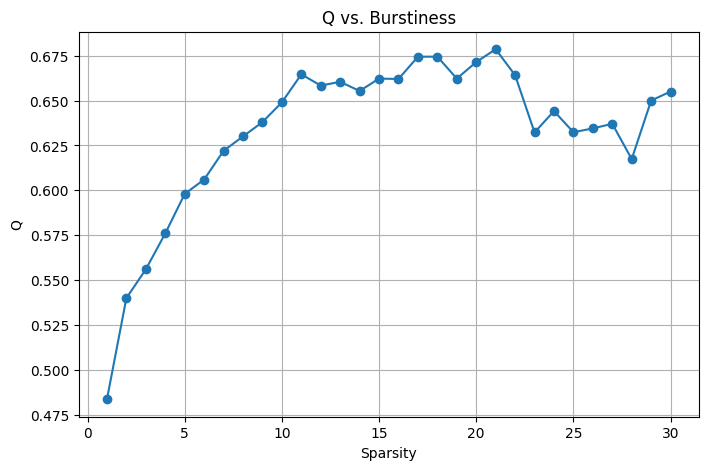

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(results_df['beta_ping'], results_df['q_stat'], marker='o')
plt.xlabel('Sparsity')
plt.ylabel('Q')
plt.title('Q vs. Burstiness')
plt.grid(True)

#plt.savefig("q_vs_burstiness.png")
plt.show()

### Fix DBSCAN parameterization: fine vs coarse. Vary sparsity by changing pings per hour.

In [16]:
seeds = range(100, 150)
sparsity_range = range(1, 15)
dbscan_params = [(240, 2, 2), (60, 0.5, 3)]
beta_start = 90
beta_ping = 4

results = np.zeros((len(seeds), len(sparsity_range), len(dbscan_params), 8))

for i, seed in enumerate(seeds):
    Bethany = Agent('Bethany',
                    'h-x13-y9',
                    'w-x3-y13',
                    city,
                    destination_diary=destination)
    population.add_agent(Bethany, verbose=False)
    population.generate_trajectory(Bethany, seed=seed, dt=1)

    for j, pph in enumerate(sparsity_range):
        beta_durations = (pph * beta_start * beta_ping) / 60
        hier_nhpp_param = (beta_start, beta_durations, beta_ping)
        Bethany.sample_traj_hier_nhpp(*hier_nhpp_param, seed=seed)

        for k, dbscan_param in enumerate(dbscan_params):
            dbscan_out = sd.temporal_dbscan(Bethany.sparse_traj, *dbscan_param)
            stop_table = sd.generate_stop_table(Bethany.sparse_traj, dbscan_out)

            if stop_table.empty:
                prepared_diary, _ = prepare_diary(Bethany)
                n_stops = np.sum(prepared_diary['stop_id'].unique() > 0)

                results[i, j, k, 0] = pph
                results[i, j, k, 1] = 0  # Recall
                results[i, j, k, 2] = 0  # Precision
                results[i, j, k, 3] = None  # Weighted Stop Merging
                results[i, j, k, 4] = None  # Move Merging
                results[i, j, k, 5] = n_stops  # Stops missed
                results[i, j, k, 6] = None  # Stops split
                results[i, j, k, 7] = None  # q
                continue

            stop_table['location'] = stop_table.apply(lambda row: city.get_block((row.centroid_x, row.centroid_y)).id, axis=1)
            metrics_df, metrics = cluster_metrics(stop_table, Bethany)

            results[i, j, k, 0] = pph
            results[i, j, k, 1] = metrics['Recall']
            results[i, j, k, 2] = metrics['Precision']
            results[i, j, k, 3] = metrics['Weighted Stop Merging']
            results[i, j, k, 4] = metrics['Move Merging']
            results[i, j, k, 5] = metrics['Missed']
            results[i, j, k, 6] = metrics['Split']
            results[i, j, k, 7] = q_stat(Bethany)

    print(seed)

results_sparsity = np.nanmean(results, axis=0)

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


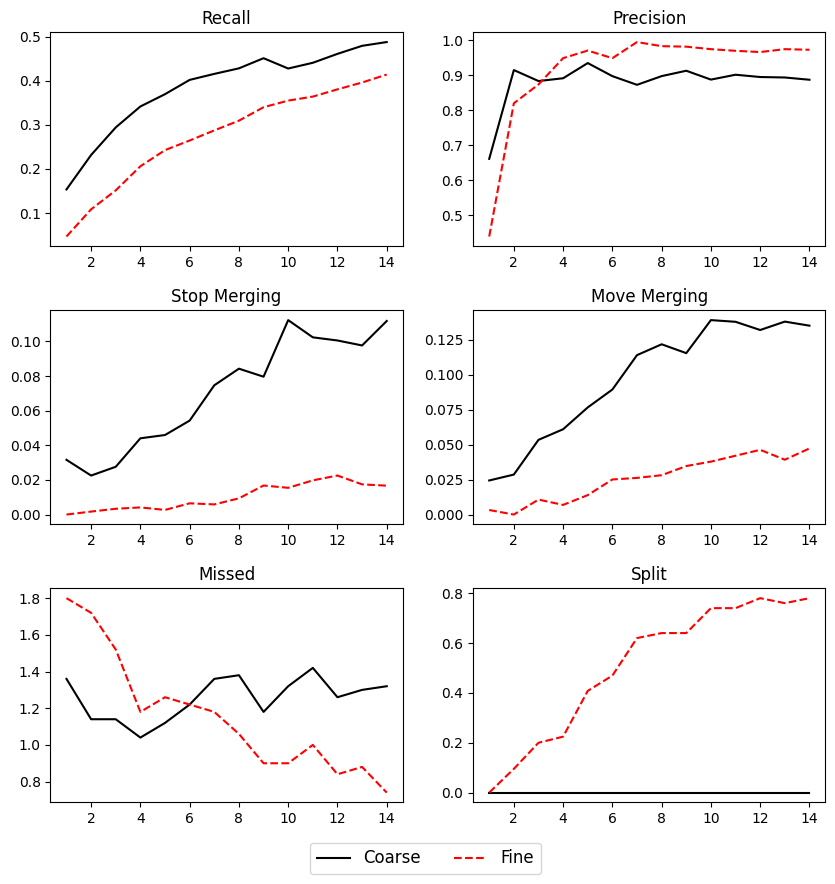

In [17]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

for i in range(6):
    ax = axes[i//2, i % 2]
    for j in range(2):
        results_df = pd.DataFrame(
            results_sparsity[:, j, :],
            columns=['pph', 'recall', 'precision', 'weighted_stop_merging', 'move_merging', 'missed', 'split', 'q_stat'])
        ax.plot(results_df['pph'], results_df.iloc[:, i+1],
                label=['Coarse', 'Fine'][j], color=['black', 'red'][j], linestyle=['-', '--'][j])
        ax.set_title(['Recall', 'Precision', 'Stop Merging', 'Move Merging', 'Missed', 'Split'][i])
        ax.set_ylabel('')

#fig.suptitle('Metrics v.s. Sparsity', fontsize=20)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize='large',
           ncol=2, bbox_to_anchor=(0.5, 0.03))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

plt.savefig("metrics_vs_sparsity.png")
plt.show()

### Fix sparsity. Vary DBSCAN parameters.

In [18]:
seeds = range(100, 150)
hier_nhpp_params = [(90, 18, 4), (90, 72, 4)]  # 3pph, 12pph

# dbscan_params = (time_thresh, dist_thresh, min_pts)
dist_threshs = np.arange(0.25, 5.5, 0.25)

results = np.zeros((len(seeds), len(hier_nhpp_params), len(dist_threshs), 8))

for i, seed in enumerate(seeds):
    Bethany = Agent('Bethany',
                    'h-x13-y9',
                    'w-x3-y13',
                    city,
                    destination_diary=destination)
    population.add_agent(Bethany, verbose=False)
    population.generate_trajectory(Bethany, seed=seed, dt=1)

    for j, hier_nhpp_param in enumerate(hier_nhpp_params):
        Bethany.sample_traj_hier_nhpp(*hier_nhpp_param, seed=seed)

        for k, dist_thresh in enumerate(dist_threshs):
            dbscan_param = (240, dist_thresh, 2)
            dbscan_out = sd.temporal_dbscan(Bethany.sparse_traj, *dbscan_param)
            stop_table = sd.generate_stop_table(Bethany.sparse_traj, dbscan_out)

            if stop_table.empty:
                prepared_diary, _ = prepare_diary(Bethany)
                n_stops = np.sum(prepared_diary['stop_id'].unique() > 0)

                results[i, j, k, 0] = dist_thresh
                results[i, j, k, 1] = 0  # Recall
                results[i, j, k, 2] = 0  # Precision
                results[i, j, k, 3] = None  # Weighted Stop Merging
                results[i, j, k, 4] = None  # Move Merging
                results[i, j, k, 5] = n_stops  # Stops missed
                results[i, j, k, 6] = None  # Stops split
                results[i, j, k, 7] = None  # q
                continue

            stop_table['location'] = stop_table.apply(
                lambda row: city.get_block((row.centroid_x, row.centroid_y)).id, axis=1)
            metrics_df, metrics = cluster_metrics(stop_table, Bethany)

            results[i, j, k, 0] = dist_thresh
            results[i, j, k, 1] = metrics['Recall']
            results[i, j, k, 2] = metrics['Precision']
            results[i, j, k, 3] = metrics['Weighted Stop Merging']
            results[i, j, k, 4] = metrics['Move Merging']
            results[i, j, k, 5] = metrics['Missed']
            results[i, j, k, 6] = metrics['Split']
            results[i, j, k, 7] = q_stat(Bethany)

    print(seed)

results_param = np.nanmean(results, axis=0)

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


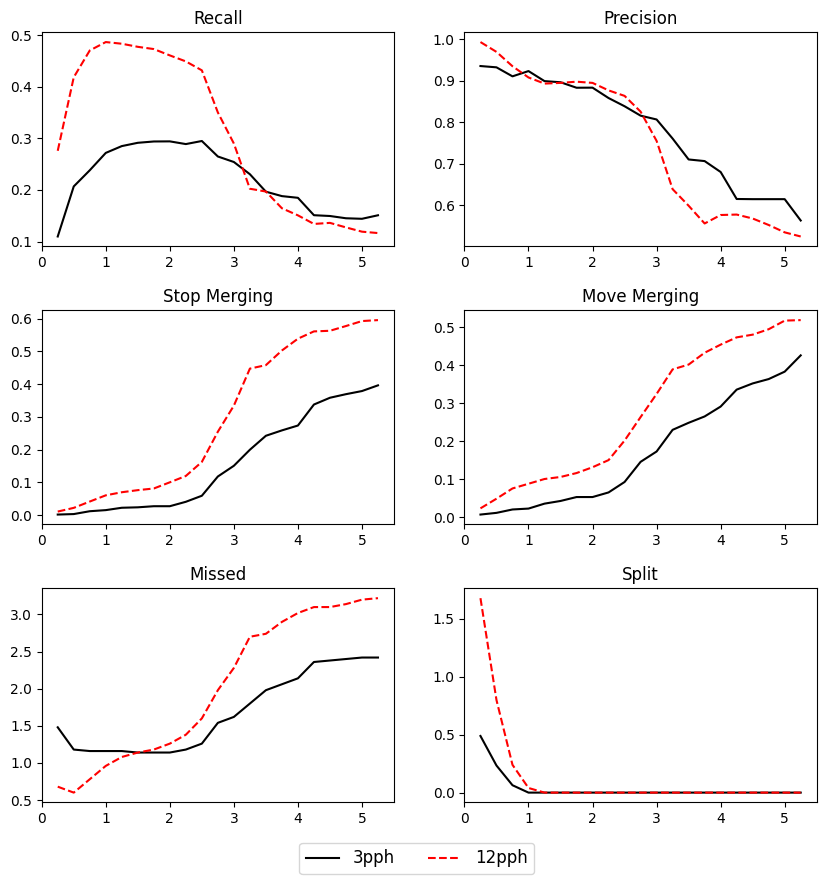

In [19]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

for i in range(6):
    ax = axes[i//2, i % 2]
    for j in range(2):
        results_df = pd.DataFrame(
            results_param[j, :, :],
            columns=['dist_thresh', 'recall', 'precision', 'weighted_stop_merging', 'move_merging', 'missed', 'split', 'q_stat'])
        ax.plot(results_df['dist_thresh'], results_df.iloc[:, i+1],
                label=['3pph', '12pph'][j], color=['black', 'red'][j], linestyle=['-', '--'][j])
        ax.set_title(['Recall', 'Precision', 'Stop Merging', 'Move Merging', 'Missed', 'Split'][i])
        ax.set_ylabel('')

#fig.suptitle('Metrics v.s. DBSCAN parameters', fontsize=20)
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize='large',
           ncol=2, bbox_to_anchor=(0.5, 0.03))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

plt.savefig("metrics_vs_params.png")
plt.show()